# Random Forest Prototype

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
FILE_PATH = '../data/gspc-etf.csv'


if os.path.exists(FILE_PATH):
    data = pd.read_csv(FILE_PATH, index_col=0)
else:
    data = yf.Ticker("^GSPC")
    data = data.history(period="max")
    data.to_csv(FILE_PATH)

In [3]:
data.index = pd.to_datetime(data.index, utc=True).date
data.index.name = 'Date'

In [4]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-14,4721.040039,4738.569824,4694.339844,4719.549805,6314040000,0.0,0.0
2023-12-15,4714.229980,4725.529785,4704.689941,4719.189941,8218980000,0.0,0.0
2023-12-18,4725.580078,4749.520020,4725.580078,4740.560059,4060340000,0.0,0.0


<Axes: xlabel='Date'>

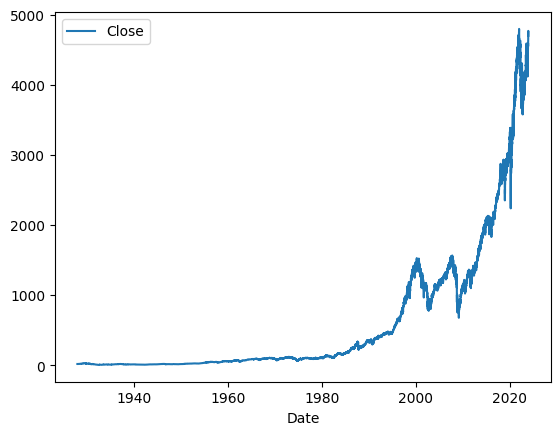

In [5]:
data.plot.line(y="Close", use_index=True)

In [6]:
del data["Dividends"]
del data["Stock Splits"]

In [7]:
data["Tomorrow"] = data["Close"].shift(-1)

In [8]:
data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)

In [9]:
data = data[data.index > pd.to_datetime("1989-12-31").date()].copy()


In [10]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [11]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5072463768115942

<Axes: xlabel='Date'>

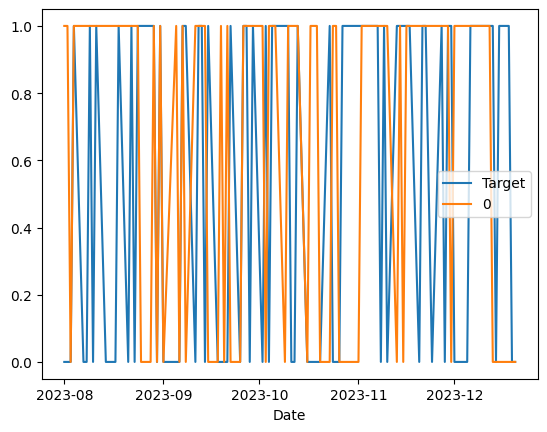

In [12]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [13]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [14]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [15]:
predictions = backtest(data, model, predictors)

In [16]:
predictions["Predictions"].value_counts()

Predictions
0    3463
1    2596
Name: count, dtype: int64

In [17]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5288906009244992

In [18]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534247
0    0.465753
Name: count, dtype: float64

In [19]:

horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [20]:
data = data.dropna(subset=data.columns[data.columns != "Tomorrow"])

In [21]:
data

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-14,4721.040039,4738.569824,4694.339844,4719.549805,6314040000,4719.189941,0,1.001322,2.0,1.012903,5.0,1.073133,36.0,1.111284,134.0,1.192991,529.0
2023-12-15,4714.229980,4725.529785,4704.689941,4719.189941,8218980000,4740.560059,1,0.999962,1.0,1.007858,4.0,1.071470,36.0,1.110293,134.0,1.192454,528.0
2023-12-18,4725.580078,4749.520020,4725.580078,4740.560059,4060340000,4768.370117,1,1.002259,1.0,1.007340,4.0,1.074613,37.0,1.114353,135.0,1.197400,528.0


In [22]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [23]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [24]:
predictions = backtest(data, model, new_predictors)


In [25]:
predictions["Predictions"].value_counts()

Predictions
0.0    4229
1.0     830
Name: count, dtype: int64

In [26]:
precision_score(predictions["Target"], predictions["Predictions"])

0.572289156626506

In [27]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.543981
0    0.456019
Name: count, dtype: float64

In [28]:
predictions

,Target,Predictions
Date,,
2003-11-14,0,0.0
2003-11-17,0,1.0
2003-11-18,1,1.0
2003-11-19,0,0.0
2003-11-20,1,1.0
...,...,...
2023-12-14,0,0.0
2023-12-15,1,0.0
2023-12-18,1,0.0
